In [1]:
cd ..

/home/janek/reasonable-embeddings


In [2]:
import numpy as np
import pandas as pd
import torch as T
import torch.nn.functional as F
import torch.nn as nn
from sklearn import metrics
from src.reasoner_mod import *
from src.generate import load_dataset, prepare_data
from src.reasoner import *
from src.utils import *
from src.vis import *


In [3]:
seed = 2022
dataset_path = 'local/out/dataset/sub-100.json'
ts = timestr()
train_onto, test_onto, data_tr, data_vl, data_te = load_dataset(dataset_path)


In [4]:
data_tr, data_vl, data_te_tr, data_te_vl, idx_te_te, X_te_te, y_te_te = prepare_data(data_tr, data_vl, data_te, seed)

In [5]:
print(np.mean(data_tr[2]))
print(np.mean(data_vl[2]))
print()
print(np.mean(data_te_tr[2]))
print(np.mean(data_te_vl[2]))
print(np.mean(y_te_te))

0.21857221508533675
0.21258330066640532

0.22166126179245282
0.207749766573296
0.20907114010562286


In [6]:
emb_size = 10
hidden_size = 16
epoch_count = 10
test_epoch_count = 10
batch_size = 32

T.manual_seed(seed)
trained_reasoner = ModifiedReasonerHead(emb_size=emb_size, hidden_size=hidden_size)
encoders = [ModifiedEmbeddingLayer.from_onto(onto, emb_size=emb_size) for onto in train_onto]

print(f'created reasoner with {paramcount(trained_reasoner)} parameters')
print(f'created {len(encoders)} encoders with {paramcount(encoders[0])} parameters each')
train_logger = train_mod(data_tr, data_vl, trained_reasoner, encoders, epoch_count=epoch_count,
                          batch_size=batch_size, identities_weight=0.101, identitity_weight_decay=0.94)

created reasoner with 3283 parameters
created 40 encoders with 1270 parameters each
train epoch 00/10 | batch 1704/1703 | loss 2.3708 | val loss 0.7716 | acc 0.2126 | f1 0.3506 | prec 0.2126 | recall 1.0000 | roc auc 0.5113 | pr auc 0.2443 | elapsed 27.52s
train epoch 01/10 | batch 1704/1703 | loss 1.6808 | val loss 0.5578 | acc 0.7418 | f1 0.3849 | prec 0.3899 | recall 0.3800 | roc auc 0.6432 | pr auc 0.4496 | elapsed 56.27s
train epoch 02/10 | batch 1704/1703 | loss 1.0830 | val loss 0.4964 | acc 0.7777 | f1 0.5297 | prec 0.4812 | recall 0.5890 | roc auc 0.7657 | pr auc 0.6032 | elapsed 55.79s
train epoch 03/10 | batch 1704/1703 | loss 0.7994 | val loss 0.4964 | acc 0.7766 | f1 0.5616 | prec 0.4818 | recall 0.6731 | roc auc 0.8008 | pr auc 0.6661 | elapsed 55.48s
train epoch 04/10 | batch 1704/1703 | loss 0.5715 | val loss 0.5380 | acc 0.7659 | f1 0.5651 | prec 0.4669 | recall 0.7157 | roc auc 0.8160 | pr auc 0.6922 | elapsed 59.23s
train epoch 05/10 | batch 1704/1703 | loss 0.4093 |

In [7]:
## --- TESTING
trained_test_encoders = {}
T.manual_seed(seed)
test_logger = TrainingLogger(validate=True, metrics=batch_stats)

for reasoner_name, reasoner in [('trained reasoner', trained_reasoner)]:
    print(reasoner_name)
    T.manual_seed(seed)
    trained_test_encoders[reasoner_name] = test_encoders = [EmbeddingLayer.from_onto(onto, emb_size=emb_size) for onto in test_onto]
    train_mod(data_te_tr, data_te_vl, reasoner, test_encoders, epoch_count=test_epoch_count, batch_size=batch_size, run_name=reasoner_name, freeze_reasoner=True, logger=test_logger, identities_weight=0.01, identitity_weight_decay=0.95)

trained reasoner
train epoch 00/10 | batch 849/848 | loss 1.0053 | val loss 1.2396 | acc 0.6309 | f1 0.4166 | prec 0.3101 | recall 0.6345 | roc auc 0.6887 | pr auc 0.4634 | elapsed 11.24s
train epoch 01/10 | batch 849/848 | loss 0.8871 | val loss 1.0963 | acc 0.6520 | f1 0.4348 | prec 0.3281 | recall 0.6442 | roc auc 0.7158 | pr auc 0.4950 | elapsed 19.09s
train epoch 02/10 | batch 849/848 | loss 0.6526 | val loss 0.9865 | acc 0.6741 | f1 0.4581 | prec 0.3499 | recall 0.6629 | roc auc 0.7413 | pr auc 0.5272 | elapsed 19.25s
train epoch 03/10 | batch 849/848 | loss 0.4841 | val loss 0.9055 | acc 0.6885 | f1 0.4754 | prec 0.3656 | recall 0.6794 | roc auc 0.7627 | pr auc 0.5571 | elapsed 19.25s
train epoch 04/10 | batch 849/848 | loss 0.3688 | val loss 0.8455 | acc 0.6969 | f1 0.4863 | prec 0.3753 | recall 0.6906 | roc auc 0.7804 | pr auc 0.5846 | elapsed 19.14s
train epoch 05/10 | batch 849/848 | loss 0.2912 | val loss 0.8001 | acc 0.7065 | f1 0.4992 | prec 0.3867 | recall 0.7041 | roc a

In [8]:
with T.no_grad():
    # idx_te, X_te, y_te = data_te
    _, _, Y_te_good = eval_batch(trained_reasoner, trained_test_encoders['trained reasoner'], X_te_te, y_te_te, idx_te_te)
    # _, _, Y_te_rand = eval_batch(random_reasoner, trained_test_encoders['random reasoner'], X_te, y_te, idx_te)

local/out/exp/20240716T224626


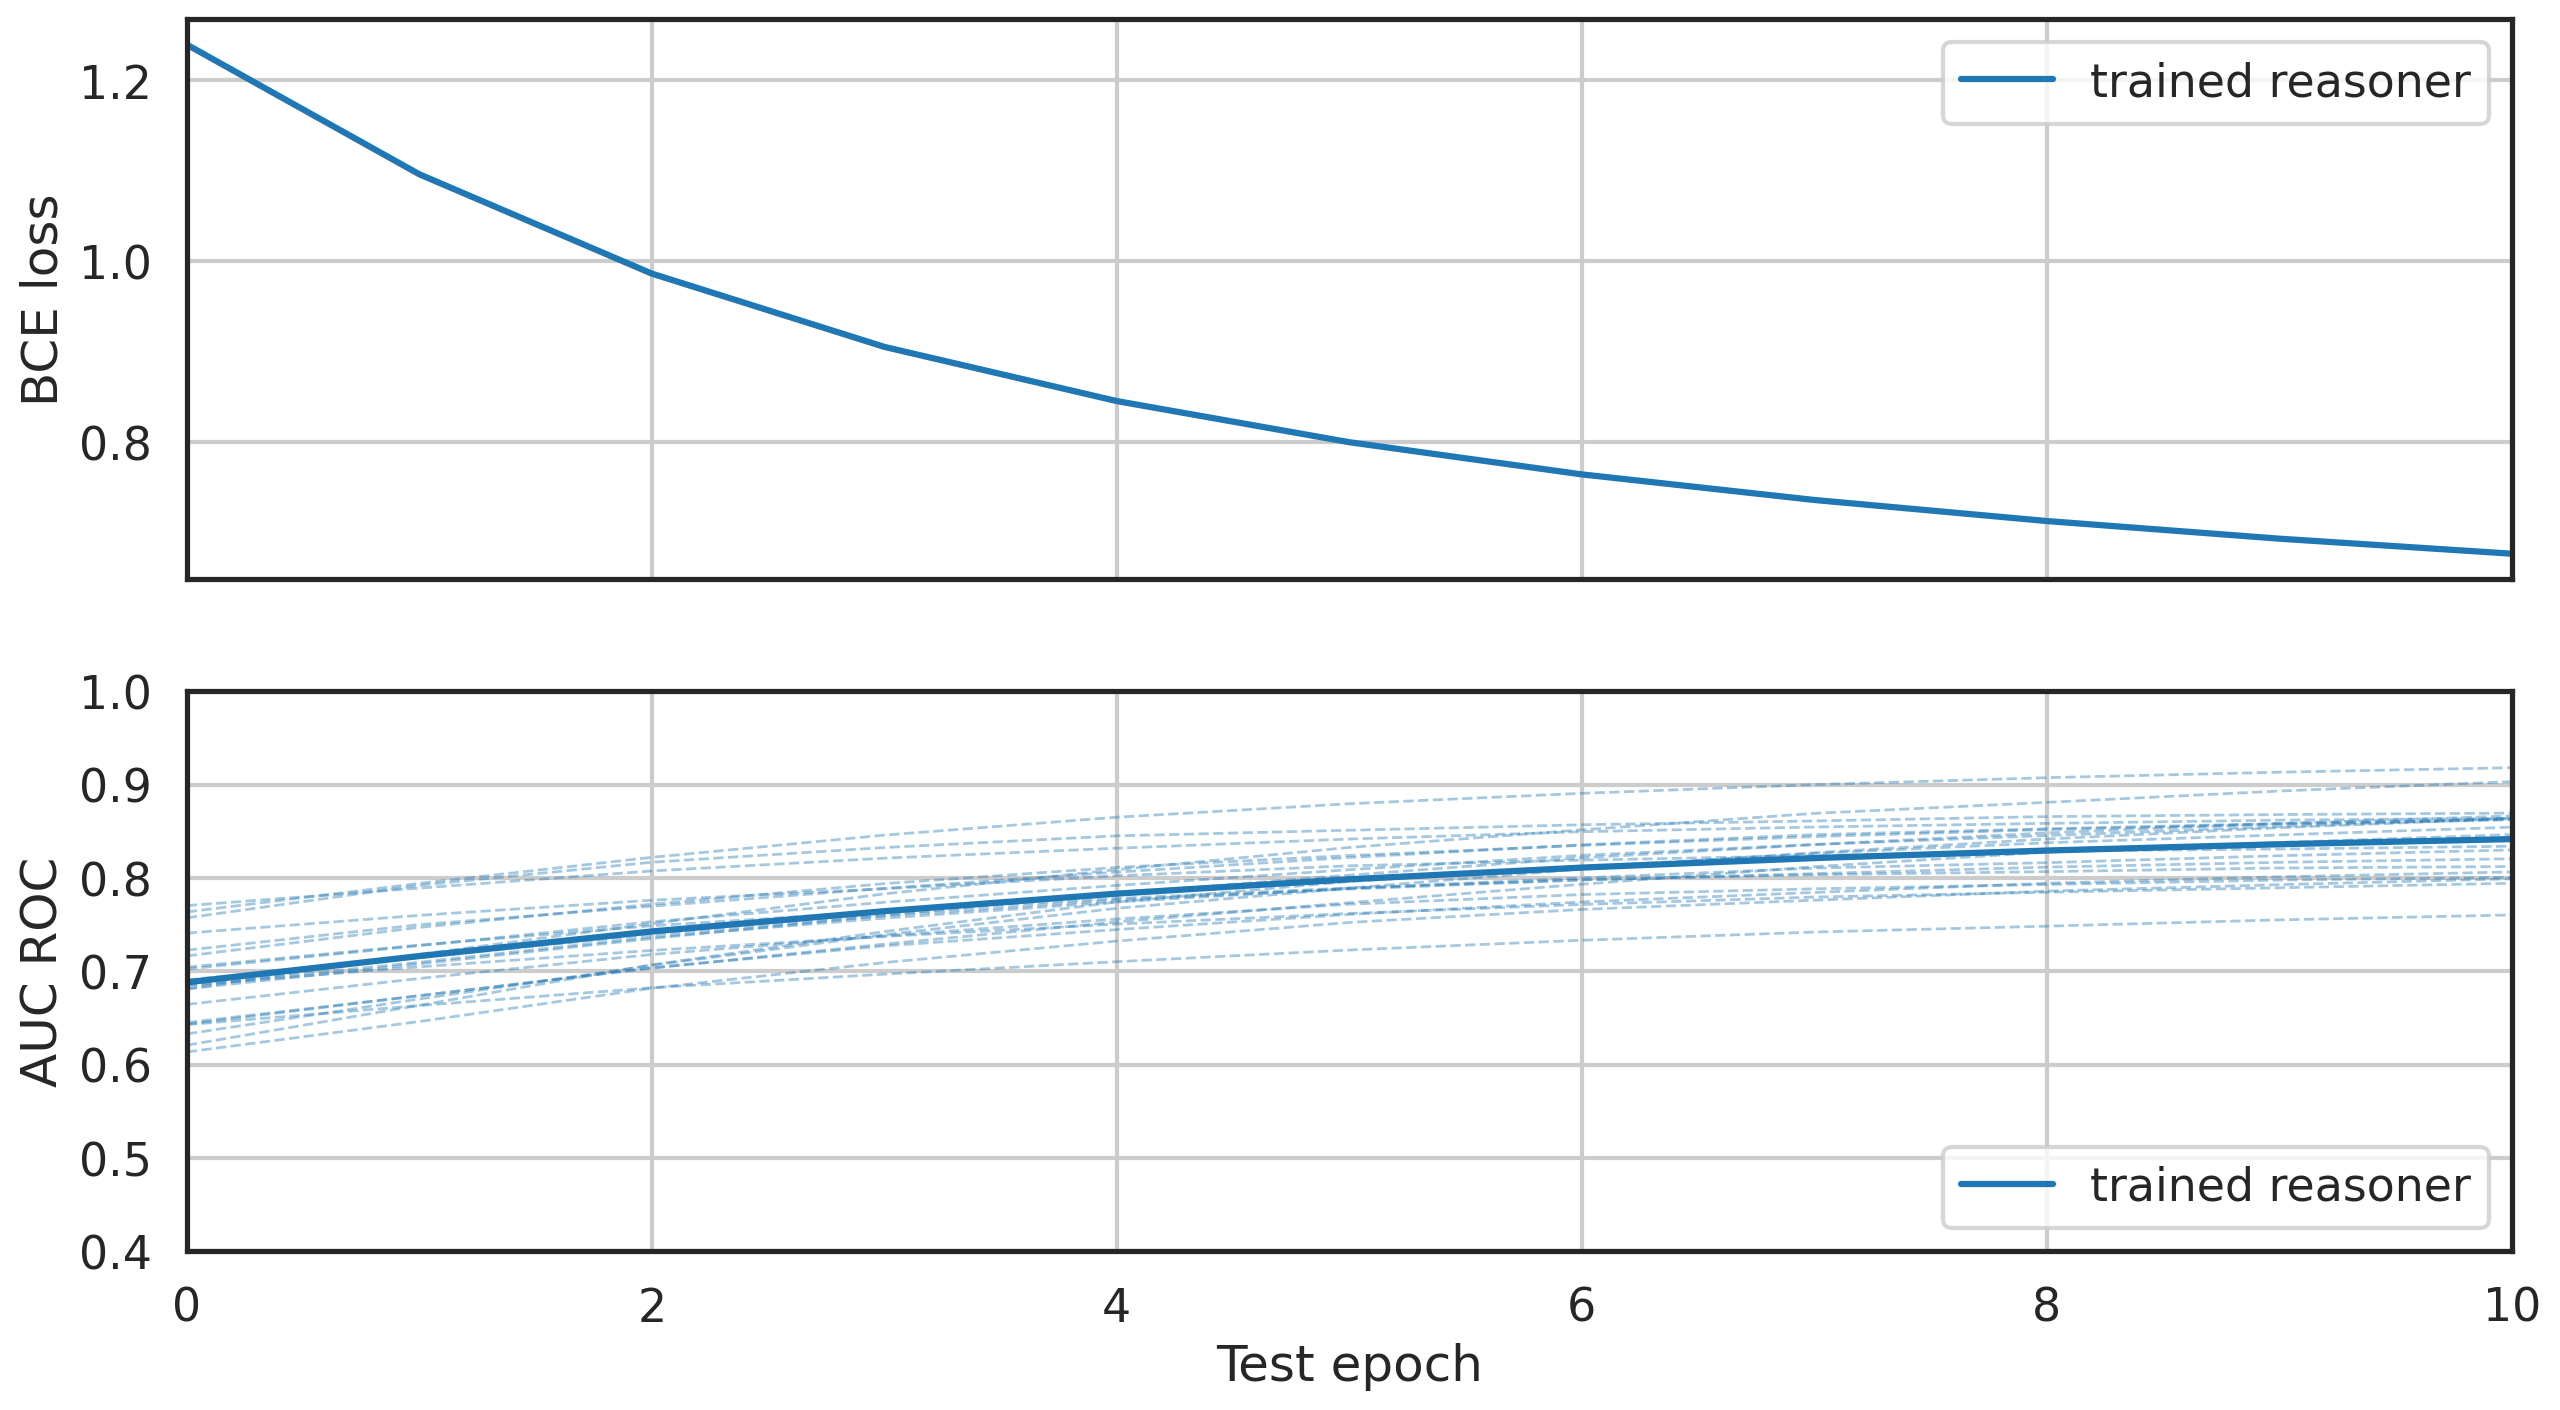

             mean       std     micro
acc      0.763570  0.061819  0.763591
prec     0.471940  0.101291  0.461027
recall   0.779384  0.060560  0.773403
f1       0.579935  0.077753  0.577691
auc_roc  0.857305  0.043264  0.854806
auc_pr   0.729778  0.090974  0.728646


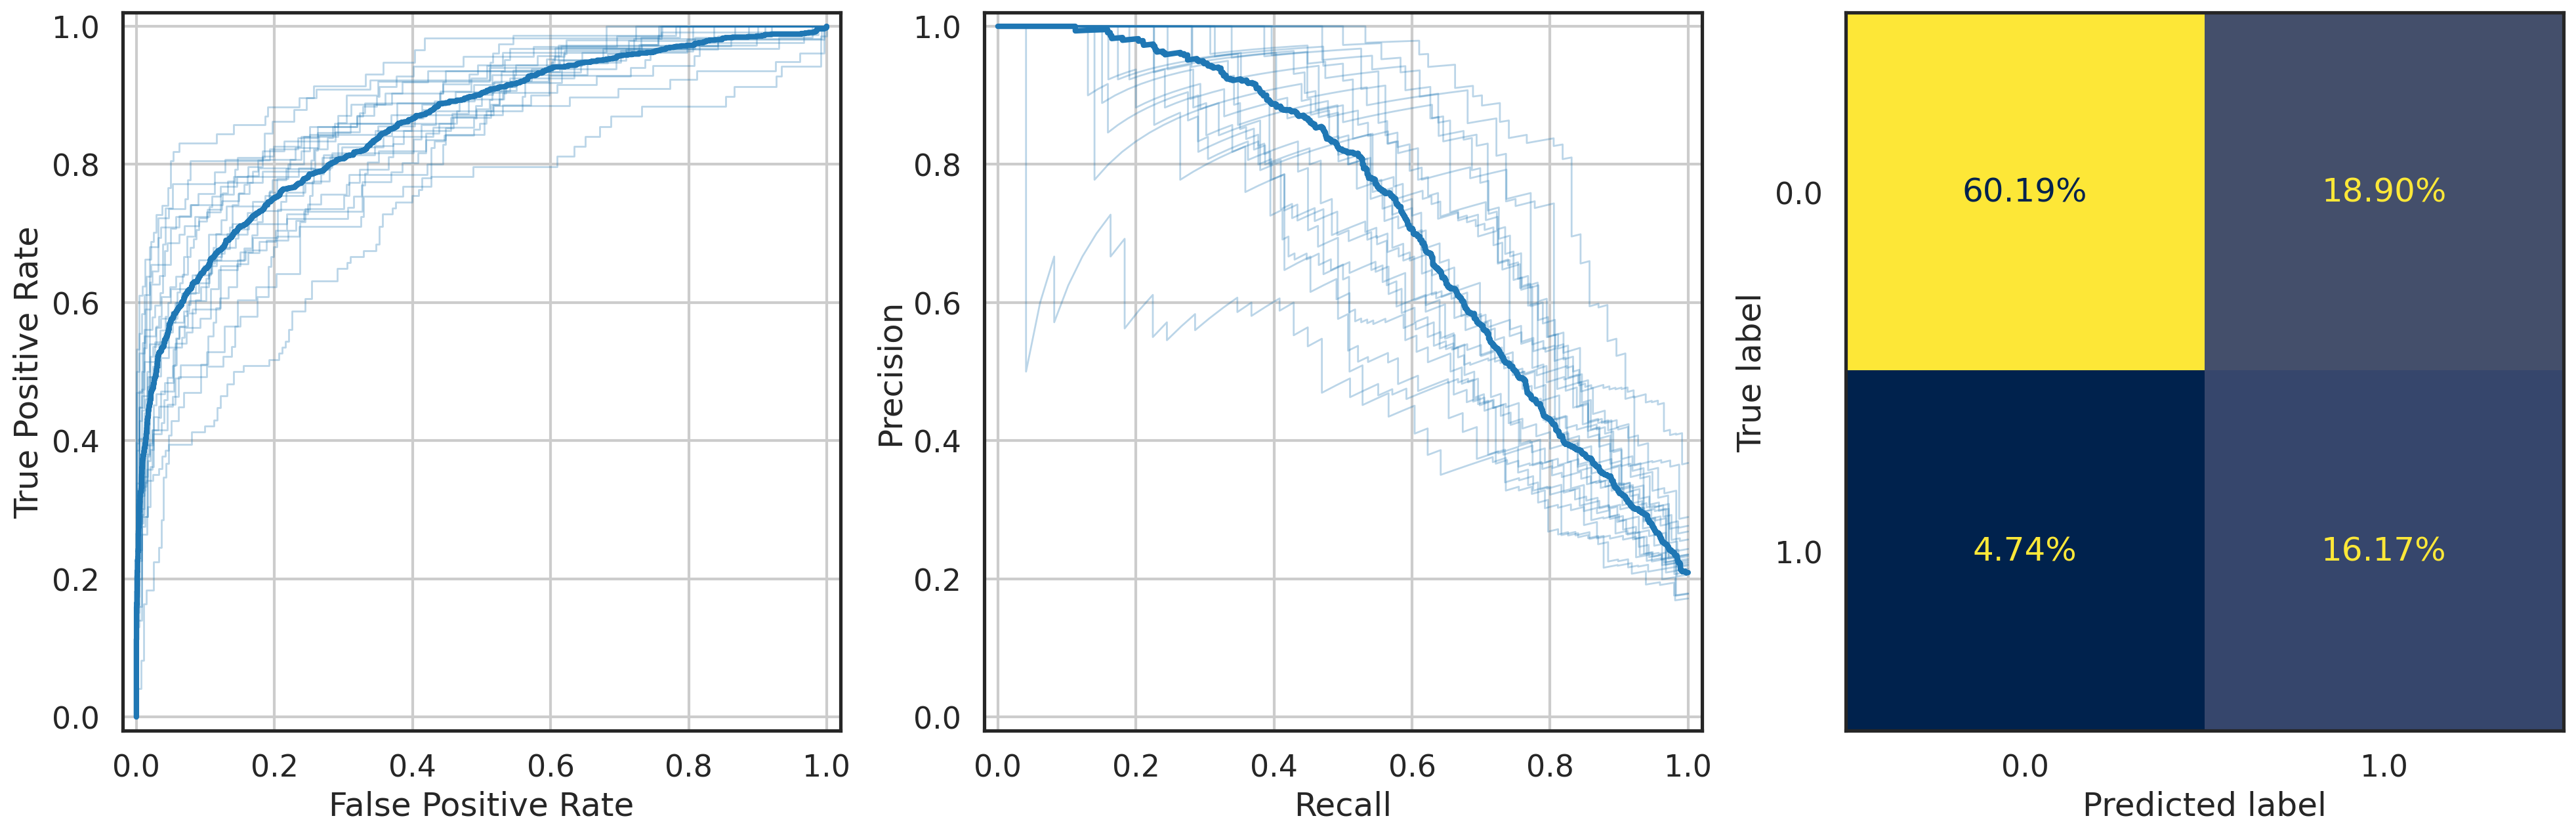

In [9]:
base = 'local/out/exp/' + ts
mkdirp(base)
print(base)

T.save(trained_reasoner.state_dict(), base+'/reasoner.pt')
# df_tr = pd.DataFrame(train_logger.history_tr)
# # df_vl = pd.DataFrame(train_logger.history_vl)
# df_tr.to_csv(base+'/train.csv', index=False)
# df_vl.to_csv(base+'/valid.csv', index=False)
# plot_train_history(df_tr, df_vl, save=base+'/train.png')

test_history_by_onto = pd.DataFrame(test_logger.history_vl_by_onto)
test_history = pd.DataFrame(test_logger.history_vl)
test_results = pd.DataFrame(dict(idx_te=idx_te_te, y_te=y_te_te, Y_te_good=Y_te_good))
test_history.to_csv(base+'/test.csv', index=False)
test_history_by_onto.to_csv(base+'/test-grouped.csv', index=False)
test_results.to_csv(base+'/test-results.csv', index=False)
plot_test_history(test_history, test_history_by_onto)
print(report(test_onto, y_te_te, np.array(Y_te_good), idx_te_te))
# print(report(test_onto, y_te, np.array(Y_te_rand), idx_te))

In [10]:
import random

In [11]:
losses = []
for _ in range(1000):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]
    losses.append( F.l1_loss(input, trained_reasoner.and_nn(im(input, input))).item() )


print(input)
print(trained_reasoner.and_nn(im( input, input)))
print(np.mean(losses))

tensor([ 0.2008, -0.0046, -0.1056, -0.1393, -0.0558, -0.0792,  0.0419, -0.0460,
         0.1712,  0.0431], grad_fn=<SelectBackward0>)
tensor([ 0.1434,  0.0656, -0.0265, -0.3082,  0.1819, -0.0949, -0.0208,  0.0007,
        -0.0055,  0.0130], grad_fn=<AddBackward0>)
0.11884708581119775


In [12]:
losses = []
for _ in range(1000):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]
    losses.append(F.l1_loss(trained_reasoner.and_nn(im(trained_reasoner.bot_concept[0], input)), trained_reasoner.bot_concept[0]).item())
print(trained_reasoner.bot_concept[0])
print(trained_reasoner.and_nn(im(trained_reasoner.bot_concept[0], input)))
print(np.mean(losses))

tensor([ 0.2295,  0.2580,  0.0668, -0.4629,  0.3658, -0.0904,  0.0320,  0.1133,
        -0.1736, -0.0952], grad_fn=<SelectBackward0>)
tensor([ 0.2547,  0.2595,  0.0622, -0.4594,  0.3959, -0.0894,  0.0381,  0.1217,
        -0.1885, -0.1033], grad_fn=<AddBackward0>)
0.018477518134284766


In [13]:
losses = []
for _ in range(1000):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]
    losses.append(F.l1_loss(trained_reasoner.and_nn(im(trained_reasoner.top_concept[0], input)), input).item())

print(input)
print(trained_reasoner.and_nn(im(trained_reasoner.top_concept[0], input)))
print(np.mean(losses))

tensor([-0.0091,  0.2428,  0.0874, -0.2621,  0.0662, -0.1469,  0.0487,  0.0438,
         0.0288,  0.0161], grad_fn=<SelectBackward0>)
tensor([ 0.0805,  0.1311,  0.0557, -0.2179,  0.1395, -0.0722,  0.0100,  0.0412,
        -0.0397, -0.0428], grad_fn=<AddBackward0>)
0.07363471709378064


In [14]:
losses = []
for _ in range(1000):

    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]
    output = trained_reasoner.and_nn(im(trained_reasoner.not_nn(input), input))
    losses.append(F.l1_loss(trained_reasoner.bot_concept[0], output).item())

print(trained_reasoner.bot_concept[0])
print(output)
print(np.mean(losses))

tensor([ 0.2295,  0.2580,  0.0668, -0.4629,  0.3658, -0.0904,  0.0320,  0.1133,
        -0.1736, -0.0952], grad_fn=<SelectBackward0>)
tensor([ 0.0392,  0.0698,  0.0688, -0.2704,  0.2063, -0.1019, -0.0668,  0.0329,
        -0.1049,  0.0143], grad_fn=<AddBackward0>)
0.09875968298316001


In [15]:
print(trained_reasoner.bot_concept[0])
output = trained_reasoner.not_nn(trained_reasoner.top_concept[0])
print(output)
print(F.l1_loss(trained_reasoner.bot_concept[0], output))

tensor([ 0.2295,  0.2580,  0.0668, -0.4629,  0.3658, -0.0904,  0.0320,  0.1133,
        -0.1736, -0.0952], grad_fn=<SelectBackward0>)
tensor([ 0.2295,  0.2578,  0.0670, -0.4623,  0.3658, -0.0905,  0.0321,  0.1133,
        -0.1733, -0.0952], grad_fn=<SqueezeBackward3>)
tensor(0.0002, grad_fn=<L1LossBackward0>)


In [16]:
print(trained_reasoner.top_concept[0])
output = trained_reasoner.not_nn(trained_reasoner.bot_concept[0])
print(output)
print(F.l1_loss(trained_reasoner.top_concept[0], output))

tensor([-0.0724, -0.1499, -0.0301,  0.5472, -0.0248,  0.0485,  0.6190,  0.1316,
        -0.0696,  0.2446], grad_fn=<SelectBackward0>)
tensor([-0.0727, -0.1502, -0.0304,  0.5474, -0.0251,  0.0490,  0.6194,  0.1317,
        -0.0698,  0.2449], grad_fn=<SqueezeBackward3>)
tensor(0.0003, grad_fn=<L1LossBackward0>)


In [17]:
losses = []
for _ in range(1000):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]

    input2 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]

    input3 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]

    losses.append(F.l1_loss(trained_reasoner.and_nn(im(input1, trained_reasoner.and_nn(im(input2, input3)))), trained_reasoner.and_nn(im(trained_reasoner.and_nn(im(input1, input2)), input3))).item())

print(trained_reasoner.and_nn(im(input1, trained_reasoner.and_nn(im(input2, input3)))))
print(trained_reasoner.and_nn(im(trained_reasoner.and_nn(im(input1, input2)), input3)))
print(np.mean(losses))

tensor([ 0.1239,  0.1210,  0.0338, -0.3347,  0.2348, -0.0939, -0.0047,  0.0431,
        -0.0777, -0.0202], grad_fn=<AddBackward0>)
tensor([ 0.1425,  0.1317,  0.0230, -0.3506,  0.2516, -0.0965, -0.0185,  0.0350,
        -0.0834, -0.0152], grad_fn=<AddBackward0>)
0.013435544398613273


In [18]:
losses = []
for _ in range(1000):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    input2 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]

    losses.append( F.l1_loss(trained_reasoner.and_nn(im(input1, input2)), trained_reasoner.and_nn(im(input2, input1))).item())

print(trained_reasoner.and_nn(im(input1, input2)))
print(trained_reasoner.and_nn(im(input2, input1)))

print(np.mean(losses))

tensor([ 0.0620, -0.0063,  0.0805, -0.2361,  0.1619, -0.1093, -0.0769, -0.0901,
         0.0423,  0.0761], grad_fn=<AddBackward0>)
tensor([ 0.1099, -0.0128,  0.0795, -0.2515,  0.1267, -0.1198, -0.0740, -0.0433,
         0.0063, -0.0006], grad_fn=<AddBackward0>)
0.016742750560399144


In [19]:
losses = []
for _ in range(1000):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    losses.append(F.l1_loss(input1, trained_reasoner.and_nn(im(input1, trained_reasoner.top_concept[0]))).item())

print(input1)
print(trained_reasoner.and_nn(im(input1, trained_reasoner.top_concept[0])))

print(np.mean(losses))

tensor([-0.1527,  0.1061,  0.0427,  0.0408, -0.0605, -0.0247, -0.0992, -0.1638,
         0.0739, -0.0884], grad_fn=<SelectBackward0>)
tensor([-0.0626, -0.0010,  0.0312,  0.0109, -0.0118, -0.0364, -0.0637, -0.0923,
         0.0570, -0.0045], grad_fn=<AddBackward0>)
0.056937456289306285


In [20]:
losses = []
for _ in range(1000):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    losses.append( T.sigmoid(trained_reasoner.sub_nn(im(input1, trained_reasoner.top_concept[0]))).item())
print(np.mean(losses))

0.9987311011552811


In [21]:
losses = []
for _ in range(1000):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    losses.append(T.sigmoid(trained_reasoner.sub_nn(im(trained_reasoner.bot_concept[0], trained_reasoner.bot_concept[0]))).item())
print(np.mean(losses))

0.9997175335884094


In [24]:
losses = []
for _ in range(1000):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]

    losses.append( F.l1_loss(input1, trained_reasoner.not_nn(trained_reasoner.not_nn(input1))).item())

print(input1)
print(trained_reasoner.not_nn(trained_reasoner.not_nn(input1)))

print(np.mean(losses))

tensor([-0.0297,  0.0211,  0.0059,  0.1142,  0.0179,  0.0339, -0.0314,  0.0087,
         0.3471, -0.0484], grad_fn=<SelectBackward0>)
tensor([-0.0297,  0.0211,  0.0059,  0.1143,  0.0179,  0.0339, -0.0314,  0.0087,
         0.3472, -0.0484], grad_fn=<SqueezeBackward3>)
7.678805542582267e-06


In [23]:
T.round(T.matmul(trained_reasoner.not_nn.weight, trained_reasoner.not_nn.weight)*100)/100

tensor([[1., 0., 0., 0., -0., 0., -0., -0., -0., -0.],
        [-0., 1., -0., 0., -0., -0., 0., -0., 0., 0.],
        [0., -0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [-0., -0., 0., 1., 0., -0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., -0., 0., 0., -0., 0.],
        [0., 0., 0., 0., -0., 1., -0., 0., -0., -0.],
        [0., -0., 0., -0., 0., 0., 1., 0., 0., -0.],
        [-0., 0., 0., 0., -0., -0., 0., 1., -0., 0.],
        [-0., 0., 0., -0., -0., -0., -0., -0., 1., 0.],
        [-0., 0., -0., -0., 0., 0., 0., 0., 0., 1.]], grad_fn=<DivBackward0>)